In [2]:
import pandas as pd

df = pd.read_csv('ab_test_data.csv')

df.head()

,user_id,timestamp,test_group,conversion
0,7f6833e6-1141-4f20-b4b2-f1e31019b1fd,2023-07-04 04:40:55.848109,a,0
1,e6a6e960-d3f3-4074-a516-ba1e609b211e,2023-07-06 00:26:45.486187,b,0
2,4d3fbfa5-6847-410a-bac2-477f01d5f400,2023-07-10 20:24:33.639464,b,0
3,361457d9-a044-48f7-981c-d67dc3861679,2023-07-20 07:04:49.957013,b,0
4,285cd63d-7d03-427f-a062-1fa2dd2e77d6,2023-07-19 23:27:50.116680,b,0


In [9]:
# Кількість користувачів у групі А
count_A = df[df['test_group'] == 'a']. shape[0]
# Кількість користувачів у групі B
count_B = df[df['test_group'] == 'b']. shape[0]

print ("Користувачів у групі A:", count_A)
print ("Користувачів у групі B:", count_B)

Користувачів у групі A: 10013
Користувачів у групі B: 9985


In [8]:
# Кількість конверсій у групі А
conv_A = df[df['test_group'] == 'a']['conversion'].sum()
# Кількість конверсій у групі B
conv_B = df[df['test_group'] == 'b']['conversion'].sum()

print("Конверсій у групі А:", conv_A)
print("Конверсій у групі B:", conv_B)

Конверсій у групі А: 611
Конверсій у групі B: 889


In [11]:
# Рівень конверсії у групі А у відсотках
cr_A = conv_A / count_A * 100
# Рівень конверсії у групі B у відсотках
cr_B = conv_B / count_B * 100

print("CR у групі А (%):", round(cr_A, 2))
print("CR у групі B (%):", round(cr_B, 2))

CR у групі А (%): 6.1
CR у групі B (%): 8.9


In [12]:
# Перетворимо колонку у формат datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [13]:
# Дата початку тесту 
start_date = df['timestamp'].min()
print("Дата початку тесту:",start_date.date())

Дата початку тесту: 2023-07-03


In [14]:
# Дата кінця тесту 
end_date = df['timestamp'].max()
print("Дата кінця тесту:", end_date.date())

Дата кінця тесту: 2023-07-25


In [15]:
# Тривалість тесту у днях
duration_days = (end_date - start_date).days + 1
print("Тривалість тесту (дні):", duration_days)

Тривалість тесту (дні): 22


In [23]:
# --- Z-тест для A/B тесту ---

# Зведена пропорція
p_pool = (conv_A + conv_B) / (count_A + count_B)

# Стандартна помилка різниці пропорцій
import math
SE = math.sqrt(p_pool * (1 - p_pool) * (1/count_A + 1/count_B))

# Z-статистика
Z = (cr_B - cr_A) / SE

# P-value для альтернативної гіпотези B > A
from scipy.stats import norm
p_value = 1 - norm.cdf(Z)

# --- Вивід результатів ---
print("Статистичний критерій:Z-тест для двох пропорцій")
print("cr_A:", round(cr_A, 4))
print("cr_B:", round(cr_B, 4))
print("Z-статистика:", round(Z,3))
print("p-value:", round(p_value,5))

# --- Перевірка нульової гіпотези ---
alpha = 0.05
if p_value < alpha:
    print("Нульову гіпотезу відхиляємо: конверсія у групі B статистично більша за групу A.")
else:
    print("Нульову гіпотезу не відхиляємо: недостатньо доказів, щоб стверджувати, що конверсія B більша за A.")

Статистичний критерій:Z-тест для двох пропорцій
cr_A: 6.1021
cr_B: 8.9034
Z-статистика: 751.968
p-value: 0.0
Нульову гіпотезу відхиляємо: конверсія у групі B статистично більша за групу A.


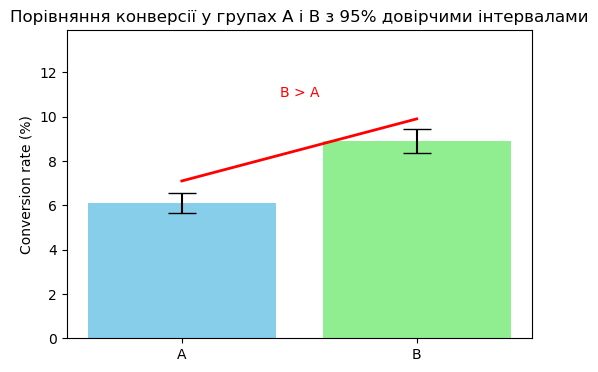

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Дані
groups = ['A', 'B']
conversion = [cr_A, cr_B]  # CR у відсотках
n_users = [count_A, count_B]

# Обчислення 95% довірчих інтервалів
conf_intervals = []
for cr, n in zip(conversion, n_users):
    p = cr / 100
    se = np.sqrt(p * (1 - p) / n)
    lower = (p - 1.96 * se) * 100
    upper = (p + 1.96 * se) * 100
    conf_intervals.append((lower, upper))

error_lower = [cr - ci[0] for cr, ci in zip(conversion, conf_intervals)]
error_upper = [ci[1] - cr for cr, ci in zip(conversion, conf_intervals)]
error = [error_lower, error_upper]

# Побудова графіку
fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(groups, conversion, yerr=error, capsize=10, color=['skyblue', 'lightgreen'])

# Додаємо підкреслення різниці між групами
ax.plot([0,1], [conversion[0]+1, conversion[1]+1], color='red', linewidth=2)  # червона лінія зверху
ax.text(0.5, max(conversion)+2, "B > A", color='red', ha='center')

ax.set_ylabel('Conversion rate (%)')
ax.set_title('Порівняння конверсії у групах A і B з 95% довірчими інтервалами')
ax.set_ylim(0, max(conversion)+5)

plt.show()

## Висновки щодо результатів А/Б-тесту

Мета тесту  
Нульова гіпотеза: пропозиція тижневої підписки $4,99 зі знижкою 50% не збільшує конверсію серед усіх встановлень додатку.  
Альтернативна гіпотеза: конверсія у групі B (з пропозицією) більша, ніж у групі A (контрольна).

Результати аналізу  

| Група | Користувачів | Конверсій | Conversion rate (%) |
|-------|---------------|------------|-------------------|
| A     | 10 013        | 611        | 6.1               |
| B     | 9 985         | 889        | 8.9               |

- Z-статистика: 751.968  
- P-value: 0.0 (p < 0.05)  
- Критерій: Z-тест для двох пропорцій  

Інтерпретація статистики  
- P-value = 0.0 < 0.05 → нульову гіпотезу відхиляємо.  
- Конверсія у групі B статистично значно вища, ніж у групі A.  
- Побудовані 95% довірчі інтервали для CR показують, що нижня межа групи B все одно вище за конверсію групи A.

Висновок та рекомендації  
- Пропозиція тижневої підписки $4,99 зі знижкою 50% покращує конверсію.  
- Рекомендується впровадити таку пропозицію для всіх користувачів.  
- Результати тесту коректні, оскільки вибірки достатньо великі, а аналіз проведено з урахуванням 95% довірчих інтервалів.

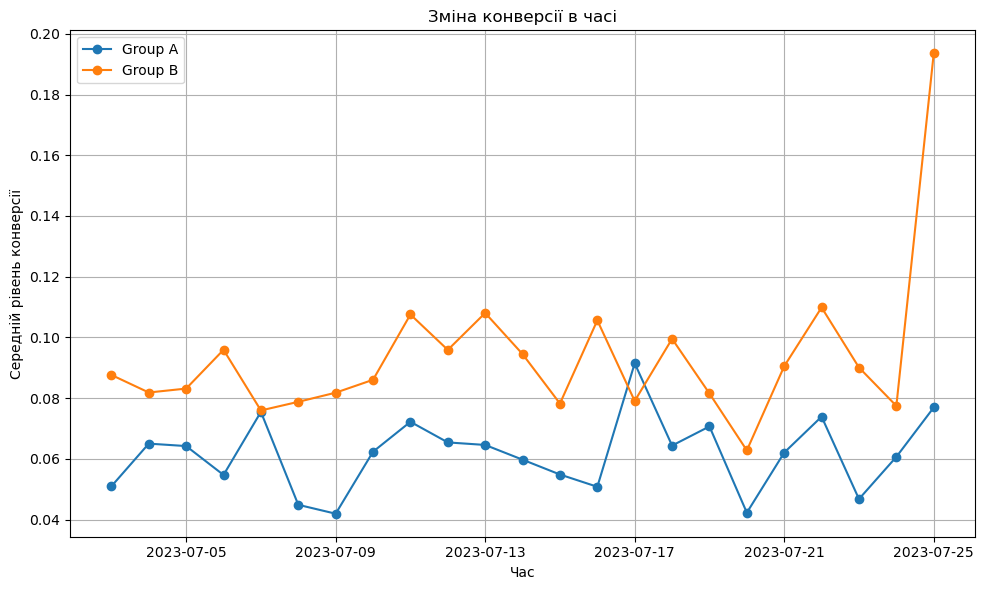

In [31]:
import matplotlib.pyplot as plt

# 1. Переконуємось, що індекс — datetime (у тебе це вже так, але безпечно перевірити)
df.index = pd.to_datetime(df.index)

# 2. Групуємо по часу (наприклад, по днях) і тестовій групі
conversion_time = (
    df
    .groupby([pd.Grouper(freq='D'), 'test_group'])['conversion']
    .mean()
    .reset_index()
)

# 3. Будуємо графік
plt.figure(figsize=(10, 6))

for group in conversion_time['test_group'].unique():
    subset = conversion_time[conversion_time['test_group'] == group]
    plt.plot(
        subset['timestamp'],
        subset['conversion'],
        marker='o',
        label=f'Group {group.upper()}'
    )

plt.title('Зміна конверсії в часі')
plt.xlabel('Час')
plt.ylabel('Середній рівень конверсії')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()